## Data Distribution

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from CNN.utility import train_routine

SPLIT_PERC = {'train': 0.8, 'val': 0.2}
DATA_DIR = os.path.join('data', 'mammals_calls')
TO_TRAIN = False
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
subfolders = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]
data_info = {}
for subfolder in subfolders:
    species_name = os.path.basename(subfolder)
    file_count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
    data_info[species_name] = file_count
count_df = pd.DataFrame(list(data_info.items()), columns=['species', 'file_count'])
count_df = count_df.sort_values(by='file_count', ascending=False)


In [ ]:
count_thousands = count_df[count_df['file_count'] > 1000]
count_hundreds = count_df[(count_df['file_count'] > 100) & (count_df['file_count'] < 1000)]
count_tens = count_df[count_df['file_count'] < 100]

plt.figure(figsize=(15, 6))
plt.bar(count_thousands['species'], count_thousands['file_count'], color="#87CEEB")
plt.bar(count_hundreds['species'], count_hundreds['file_count'], color='#00688B')
plt.bar(count_tens['species'], count_tens['file_count'], color="#191970")
plt.xlabel('Species')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Log Scaled Number of Spectrograms')
plt.yscale("log")
plt.title('Number of Spectrograms per Species')

plt.tight_layout()
plt.show()

print(f'Total number of species: {count_df.shape[0]}')
print(f'Number of species with more than 1000 spectrograms: {count_thousands.shape[0]}')
print(f'Number of species with more than 100 but less than 1000 spectrograms: {count_hundreds.shape[0]}')
print(f'Number of species with less than 100 spectrograms: {count_tens.shape[0]}')


## Training CNN

In [ ]:
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")
MODELS_METRICS_DIR = os.path.join("models_metrics")
PATIENCE = 3
if not os.path.exists(MODELS_METRICS_DIR):
    os.makedirs(MODELS_METRICS_DIR)

split_perc = {'train': 0.8, 'val': 0.2}

Training della CNN classica con le classi che contengono più di 1000 sample.

In [ ]:

n_classes_1000 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), to_train=TO_TRAIN, cardinality=999)

Si ripete il training aggiungendo 10 classi per volta in ordine decrescente in numero di sample contenuti.

In [ ]:
#Fino a classe 23
n_classes_plus_10 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_1000, 10), to_train=TO_TRAIN)

In [ ]:
#Fino a classe 33
n_classes_plus_20 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_10, 10), to_train=TO_TRAIN)

In [ ]:
#Fino a classe 43
n_classes_plus_30 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_20, 10), to_train=TO_TRAIN)

In [ ]:
#Fino all'ultima classe
n_classes_plus_rem = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_30, 10), to_train=True)

## Output Plots

In [ ]:
def get_class_metrics(row, all_classes_df, metrics_list):
    for metric in metrics_list:
        class_num = row['index']
        col_name = rf'{class_num}_{metric}'
        class_metrics = all_classes_df[col_name]
        row[metric] = class_metrics
    return row


all_classes_df = pd.read_csv(MODELS_METRICS_DIR + f'/{n_classes_plus_rem}_CNN_metrics.csv')
all_classes_df = all_classes_df.loc[:, all_classes_df.columns.str.match(r'^\d')]
last_epoch_metrics = all_classes_df.iloc[-1]

classes_df = pd.read_csv(MODELS_METRICS_DIR + f'/{n_classes_plus_rem-1}_label_to_index.csv')

metrics_list = ['precision', 'recall', 'f1-score', 'support']
classes_df = classes_df.apply(get_class_metrics, axis=1, all_classes_df=last_epoch_metrics, metrics_list=metrics_list)

print(classes_df.sort_values(by='support'))
classes_df.to_csv('merged_metrics.csv', index=False)

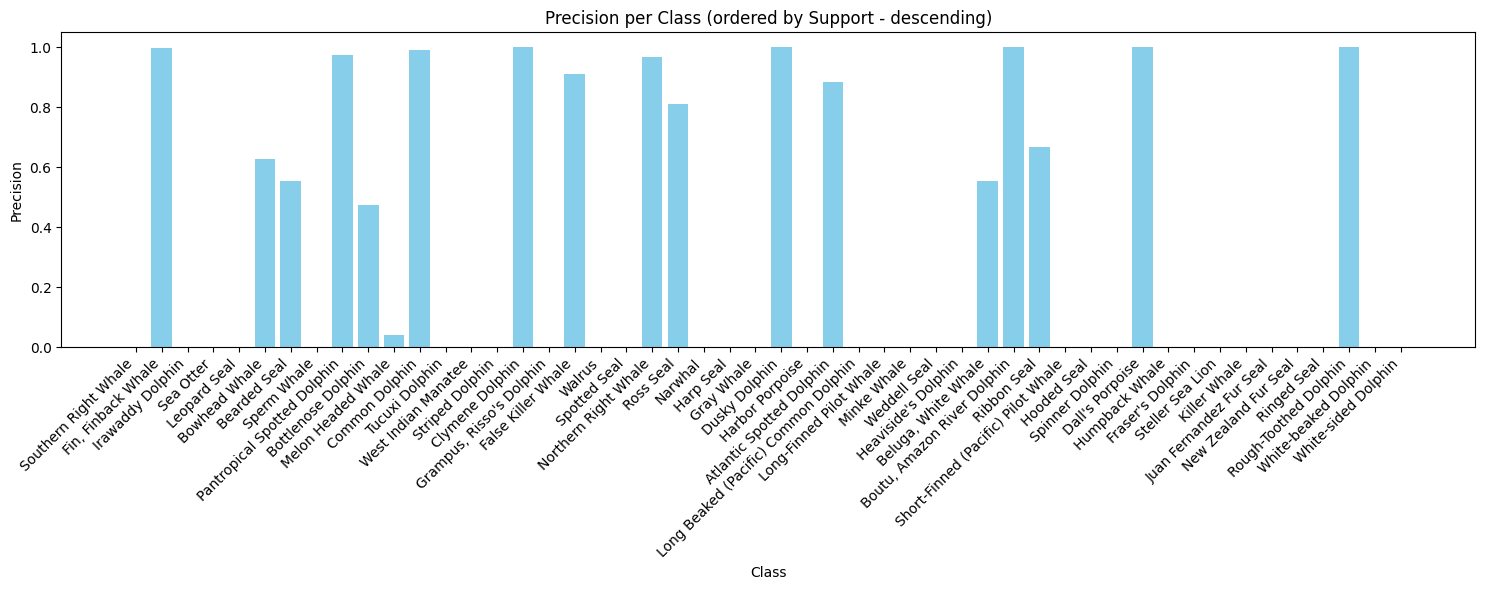

In [ ]:
plt.figure(figsize=(15, 6))

classes_df_sorted = classes_df.sort_values(by='support', ascending=False)

plt.bar(classes_df_sorted['label'], classes_df_sorted['precision'], color="#87CEEB")
plt.xlabel('Class')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Precision')
plt.title('Precision per Class (ordered by Support - descending)')
plt.tight_layout()
plt.show()